In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os, re

In [7]:
def loadRuns(path="../"):
    runs = {}

    run_RE = re.compile("slurm-([0-9]+)(.out|)$")
    bs_RE = re.compile("Train Buffer Size: 0, training batch size: ([0-9]+)")
    ranks_RE = re.compile("ranks [0-9]+ ([0-9]+)")
    lrscale_RE = re.compile("lrScaling ([a-zA-Z0-9]+)")

    for fn in os.listdir(path):
        m = run_RE.match(fn)
        if not m:
            continue

        i = int(m[1])
        if i in runs:
            run = runs[i]
        else:
            run = {"i": i}
        if m[2] == ".out":
            with open(os.path.join(path, fn)) as f:
                lines = f.readlines()

            for l in lines:
                m = bs_RE.match(l)
                if m:
                    run["bs"] = int(m[1])
                    break

            ranks = 0
            for l in lines:
                m = ranks_RE.match(l)
                if m:
                    ranks += 1
            if ranks == 0:
                raise RuntimeError("No ranks in run {}".format(fn))
            run["ranks"] = ranks
                
            for l in lines:
                m = lrscale_RE.match(l)
                if m:
                    run["lrscale"] = m[1]
                    break
            
            runs[i] = run
    return runs

In [18]:
path="../oldBSruns/"
path="../fixedBSruns/"
path="../"

runs = loadRuns(path)
runs

{6919037: {'i': 6919037, 'bs': 16, 'ranks': 1, 'lrscale': 'lin'},
 6919036: {'i': 6919036, 'bs': 20, 'ranks': 1, 'lrscale': 'lin'},
 6918921: {'i': 6918921, 'bs': 2, 'ranks': 1, 'lrscale': 'lin'},
 6919038: {'i': 6919038, 'bs': 8, 'ranks': 1, 'lrscale': 'lin'},
 6918919: {'i': 6918919, 'bs': 4, 'ranks': 1, 'lrscale': 'lin'},
 6919039: {'i': 6919039, 'bs': 4, 'ranks': 1, 'lrscale': 'lin'}}

In [19]:
def plotLosses(col, runs=runs, title=None):
    for r in runs.values():
        i = r["i"]
        if not "dat" in r:
            r["dat"] = np.loadtxt(f"{path}/slurm-{i}/loss_0.dat")
        dat = r["dat"]
        #print(i, dat.shape)
        if "lrscale" in r:
            lrscale = r["lrscale"]
        else:
            lrscale = "1"
        linestyle = "-"
        if lrscale == "sqrt":
            linestyle = ":"
        plt.plot(dat[:, 0], dat[:, col], label=("{}: r{} bs{} lrs{}".format(i, r["ranks"], r["bs"], lrscale)),
                ls=linestyle)
    if title is None:
        plt.title(f"col {col}")
    else:
        plt.title(title)
    #plt.ylim((0,10))
    plt.legend()

(0.0, 20.0)

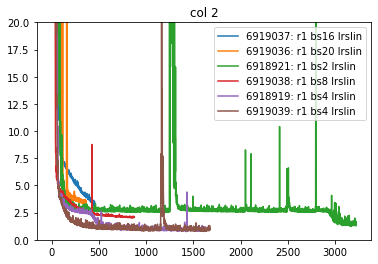

In [20]:
plotLosses(2)
plt.ylim((0,20))

(0.0, 1.0)

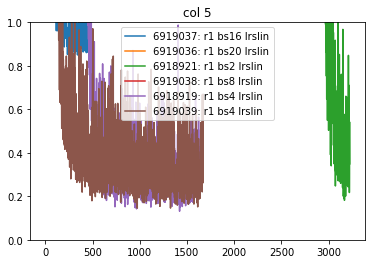

In [21]:
plotLosses(5)
plt.ylim((0,1))

In [158]:
for r in runs.values():
    dat = r["dat"]
    print(r["i"], r["ranks"], r["bs"], np.mean(dat[10:,1]))

6917424 1 8 2679.9640484564284
6917423 4 8 2750.2698029754724
6917428 1 8 2680.0588928150764
6917425 2 8 2718.3196981731535
6917426 2 8 2721.024293110315
6917427 4 8 2751.635189669088
